In [ ]:
!wget -r -np -R index.html "https://7a0a-126-170-21-44.ngrok-free.app/Deep-Emotion/Expw.zip"

!mv /content/7a0a-126-170-21-44.ngrok-free.app/Deep-Emotion/Expw.zip /content/

!unzip /content/Expw.zip

!pip install opacus

!pip install wandb

!pip install optuna

!pip install imgaug

串流輸出內容已截斷至最後 5000 行。
  inflating: Expw-F/train/sad/34566crying_asian_322.jpg  
  inflating: Expw-F/train/sad/35103crying_chinese_178.jpg  
  inflating: Expw-F/train/sad/4285annoyed_face_120.jpg  
  inflating: Expw-F/train/sad/10553fighting_son_772.jpg  
  inflating: Expw-F/train/sad/36659crying_grandmother_540.jpg  
  inflating: Expw-F/train/sad/37523crying_mother_197.jpg  
  inflating: Expw-F/train/sad/39502crying_worker_649.jpg  
  inflating: Expw-F/train/sad/28079crying_girl_111.jpg  
  inflating: Expw-F/train/sad/28702crying_soldier_40.jpg  
  inflating: Expw-F/train/sad/46482amazed_chinese_474.jpg  
  inflating: Expw-F/train/sad/44367heartbroken_manager_107.jpg  
  inflating: Expw-F/train/sad/38992crying_teacher_141.jpg  
  inflating: Expw-F/train/sad/27902crying_european_909.jpg  
  inflating: Expw-F/train/sad/80238awe_girl_34.jpg  
  inflating: Expw-F/train/sad/31741boring_woman_243.jpg  
  inflating: Expw-F/train/sad/44330heartbroken_man_650.jpg  
  inflating: Expw-F/train/sad/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from opacus.validators import ModuleValidator
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
from torch.utils.data import DataLoader
import numpy as np
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
from opacus.grad_sample.grad_sample_module import create_or_accumulate_grad_sample
from opacus.data_loader import DPDataLoader
from opacus.grad_sample import GradSampleModule
from torchvision import datasets, transforms, models
import wandb
from torchsummary import summary
import torchvision, torch, opacus
import optuna
from functools import partial
import numpy as np
from imgaug import augmenters as iaa

In [ ]:
class Modified_Deep_Emotion(nn.Module):
  def __init__(self):
    '''
    Deep_Emotion class contains the network architecture.
    '''
    super(Modified_Deep_Emotion,self).__init__()
    self.conv1 = nn.Conv2d(1,10,3)
    self.conv2 = nn.Conv2d(10,10,3)
    self.pool2 = nn.MaxPool2d(2,2)

    self.conv3 = nn.Conv2d(10,10,3)
    self.conv4 = nn.Conv2d(10,10,3)
    self.pool4 = nn.MaxPool2d(2,2)

    self.norm = nn.BatchNorm2d(10)

    self.fc1 = nn.Linear(112360, 50)  # 更新这一行
    self.fc2 = nn.Linear(50,5)
    self.dropout = nn.Dropout(p=0.5)  # Dropout層

    self.localization = nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=7),#既然输入图像不是灰度图，我假设它是一个RGB图像。这意味着输入图像应该有3个通道。
                                           #nn.Conv2d(1, 8, kernel_size=7),
      nn.MaxPool2d(2, stride=2),
      nn.ReLU(True),
      nn.Conv2d(8, 10, kernel_size=5),
      nn.MaxPool2d(2, stride=2),
      nn.ReLU(True)
        )

    self.fc_loc = nn.Sequential(
      nn.Linear(27040, 32),
      nn.ReLU(True),
      nn.Linear(32, 3 * 2)
        )
    self.fc_loc[2].weight.data.zero_()
    self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

  def stn(self, x):
    xs = self.localization(x)

    #print("Shape of xs before flattening:", xs.shape)
    # 获取xs的形状
    batch_size, channels, height, width = xs.shape

    # 重塑xs
    xs = xs.view(batch_size, -1)

    # 再次打印xs的形状以确认重塑是否正确
    #print("Shape of xs after reshaping:", xs.shape)
    theta = self.fc_loc(xs)
    theta = theta.view(-1, 2, 3)

    grid = F.affine_grid(theta, x.size())
    x = F.grid_sample(x, grid)
    return x

  def forward(self,input):
    #print("Input shape to Deep_Emotion:", input.shape)  # Debug print
    out = self.stn(input)
    #print("Output shape after STN:", out.shape)  # Debug print

    out = F.relu(self.conv1(out))
    #print("Output shape after conv1:", out.shape)  # Debug print

    out = self.conv2(out)
    #print("Output shape after conv2:", out.shape)  # Debug print
    out = self.dropout(out)
    out = F.relu(self.pool2(out))
    #print("Output shape after pool2:", out.shape)  # Debug print

    out = F.relu(self.conv3(out))
    out = self.dropout(out)
    out = self.norm(out)
    out = F.relu(self.conv4(out))  # 使用conv4层
    #print("Output shape after conv3:", out.shape)  # Debug print

    out = F.dropout(out)

    # 获取out的形状
    batch_size, num_features, height, width = out.shape

    # 使用这些维度来计算每个输入样本的特征数量
    num_features_total = num_features * height * width

    # 使用计算出的特征数量来更新view函数的参数
    out = out.view(batch_size, num_features_total)
    out = F.relu(self.fc1(out))
    out = self.fc2(out)

    return out

In [ ]:
class CombinedModel(nn.Module):
  def __init__(self, num_classes):  # Set default value of num_classes to 5
    super(CombinedModel, self).__init__()

    # ResNet-18 model
    self.resnet18 = model_resnet
    # Remove the last layer to get features
    modules = list(self.resnet18.children())[:-1]
    self.resnet18 = nn.Sequential(*modules)

    # Modified_Deep_Emotion model
    self.deep_emotion = Modified_Deep_Emotion()

    # Fully connected layer
    self.fc = nn.Linear(517, num_classes)  # 512 from ResNet-18 and 53 from Modified_Deep_Emotion

  def forward(self, x):
    x1 = self.resnet18(x)
    x1 = x1.view(x1.size(0), -1)

    # Convert the input image to grayscale
    x_gray = x.mean(dim=1, keepdim=True)

    x2 = self.deep_emotion(x_gray)
    x2 = x2.view(x2.size(0), -1)

    # Concatenate features from both models
    x = torch.cat((x1, x2), dim=1)

    x = self.fc(x)
    return x

In [ ]:
# 加载预训练的模型权重, 在加载模型之前，您已经定义了模型的结构
model = torch.load('deep_emotion_expw_step1.pth')

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),

    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),

    iaa.Multiply((0.8, 1.2), per_channel=0.2),

    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order
from PIL import Image

class ImgAugTransform:
    def __init__(self, augmenters):
        self.augmenters = augmenters

    def __call__(self, img):
        img = np.array(img)
        img = self.augmenters.augment_image(img)
        return Image.fromarray(img)



In [ ]:
transform = transforms.Compose([
  ImgAugTransform(seq),
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

train_dataset = datasets.ImageFolder('/content/Expw-F/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
train_loader = DPDataLoader.from_data_loader(train_loader, distributed=False)

test_dataset = datasets.ImageFolder('/content/Expw-F/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
test_loader = DPDataLoader.from_data_loader(test_loader, distributed=False)

val_dataset = datasets.ImageFolder('/content/Expw-F/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
val_loader = DPDataLoader.from_data_loader(val_loader, distributed=False)

In [ ]:
criterion = nn.CrossEntropyLoss()

# 確保所有參數的requires_grad屬性都設置為True
for param in model.parameters():
  param.requires_grad = True

model = GradSampleModule(model)
print(f"After wrapping : {model}")


errors = ModuleValidator.validate(model, strict=False)
model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)

train_dataset = train_loader.dataset


# 定義sample_rate。這是一個超參數，您可以根據需要調整它。
# 例如，如果您希望每次迭代都使用整個數據集，則可以設置sample_rate=1.0。
sample_rate = 1.0

sampler = UniformWithReplacementSampler(
    num_samples=len(train_dataset),
    sample_rate=sample_rate
)
# 使用當前train_loader的其他設置（例如batch_size、shuffle等）來創建新的DataLoader。
train_loader = DataLoader(
    train_dataset,
    batch_sampler=sampler,
    collate_fn=train_loader.collate_fn,  # 使用原始train_loader的collate_fn
    pin_memory=train_loader.pin_memory,  # 使用原始train_loader的pin_memory設置
    # 如果您的原始train_loader有其他特定的設置，也可以在這裡添加。
)



After wrapping : GradSampleModule(CombinedModel(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): GroupNorm(1, 64, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(1, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(1, 64, eps=1e-05, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(1, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
epsilon = 1  # 目标epsilon值
delta = 1e-5  # 目标delta值 EPSILON = 50.0 DELTA = 1e-5
max_grad_norm = 1.2  # 最大梯度范数
wandb.login(key="")
# Initialize wandb
wandb.init(project="deep_emotion_project(Expw)", name="(data aug two_dataset(80%))two_emotion_before_after_add_noise_run")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: j40pl7lly (jordan_liu). Use `wandb login --relogin` to force relogin


In [ ]:
epochs = 100
model.train()
privacy_engine = PrivacyEngine()
#optimizer = torch.optim.SGD(model.parameters(), lr=5e-6, momentum=0.9 #result 60%
#optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08) #result 50%
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.99), weight_decay = 0.001)
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=epochs,
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm=max_grad_norm,
)

print(f"Using sigma={optimizer.noise_multiplier} and C={max_grad_norm}")


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:53: RuntimeWarning: divide by zero encountered in log
  t > np.log(1 - q),


Using sigma=37.8125 and C=1.2


In [ ]:
def Train(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, device, MAX_PHYSICAL_BATCH_SIZE):
    print("===================================Start Training===================================")

    model.train()
    # Training loop with BatchMemoryManager
    with BatchMemoryManager(
            data_loader=train_loader,
            max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE,
            optimizer=optimizer
        ) as memory_safe_data_loader:
        for e in range(epochs):
            train_loss = 0
            validation_loss = 0
            train_correct = 0
            val_correct = 0

            model.train()
            for data, labels in memory_safe_data_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_correct += torch.sum(preds == labels.data)

            train_loss = train_loss/len(train_dataset)
            train_acc = train_correct.double() / len(train_dataset)
            # Log training metrics
            wandb.log({"Train Loss(100%)": 100 * train_loss , "Train Accuracy(100%)": 100 * train_acc})


            model.eval()
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                val_outputs = model(data)
                val_loss = criterion(val_outputs, labels)
                validation_loss += val_loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += torch.sum(val_preds == labels.data)


            validation_loss =  validation_loss / len(val_dataset)
            val_acc = val_correct.double() / len(val_dataset)

            # Log validation metrics
            wandb.log({"Validation Loss(100%)": 100 * validation_loss, "Validation Accuracy(100%)": 100 *val_acc})

            # Step the scheduler
            scheduler.step(validation_loss)
            print('Epoch: {} \tTraining Loss: {:.8f}% \tValidation Loss {:.8f}% \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, 100*train_loss,100*validation_loss,train_acc * 100, val_acc*100))
        torch.save(model,'deep_emotion-expw_step2.pth')
        print("===================================Training Finished===================================")
        return val_acc

In [ ]:
MAX_PHYSICAL_BATCH_SIZE = 32
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
#scheduler = ReduceLROnPlateau(optimizer, step_size=10, gamma=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Train(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, device, MAX_PHYSICAL_BATCH_SIZE)

In [ ]:
Train(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, device, MAX_PHYSICAL_BATCH_SIZE)

===================================Start Training===================================


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the document

Epoch: 1 	Training Loss: 2.24202081% 	Validation Loss 2.72748243% 	Training Acuuarcy 70.918% 	Validation Acuuarcy 64.391%
Epoch: 2 	Training Loss: 2.22670587% 	Validation Loss 2.63464479% 	Training Acuuarcy 71.081% 	Validation Acuuarcy 65.994%
Epoch: 3 	Training Loss: 2.24732688% 	Validation Loss 2.67951949% 	Training Acuuarcy 70.748% 	Validation Acuuarcy 65.244%
Epoch: 4 	Training Loss: 2.25560167% 	Validation Loss 2.71196349% 	Training Acuuarcy 70.393% 	Validation Acuuarcy 65.581%
Epoch: 5 	Training Loss: 2.27863779% 	Validation Loss 2.69332837% 	Training Acuuarcy 70.156% 	Validation Acuuarcy 66.305%
Epoch: 6 	Training Loss: 2.27596415% 	Validation Loss 2.79669431% 	Training Acuuarcy 70.045% 	Validation Acuuarcy 67.132%
Epoch: 7 	Training Loss: 2.29585919% 	Validation Loss 2.69237194% 	Training Acuuarcy 69.860% 	Validation Acuuarcy 65.270%
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 8 	Training Loss: 2.31927553% 	Validation Loss 2.88403827% 	Training Acuuarcy

tensor(0.6584, device='cuda:0', dtype=torch.float64)

In [ ]:
### test the picture


In [ ]:
from google.colab import files
# Save the model

model_path = '/content/deep_emotion-expw_step2.pth'
torch.save(model, model_path)

# Download the model to your local system
files.download(model_path)

#models = torch.load('deep_emotion_expw_step1.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # 将模型设置为评估模式
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 禁用梯度计算
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    return test_loss, accuracy

# 训练后，在测试集上评估模型
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.8813, Test Accuracy: 65.85%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the document

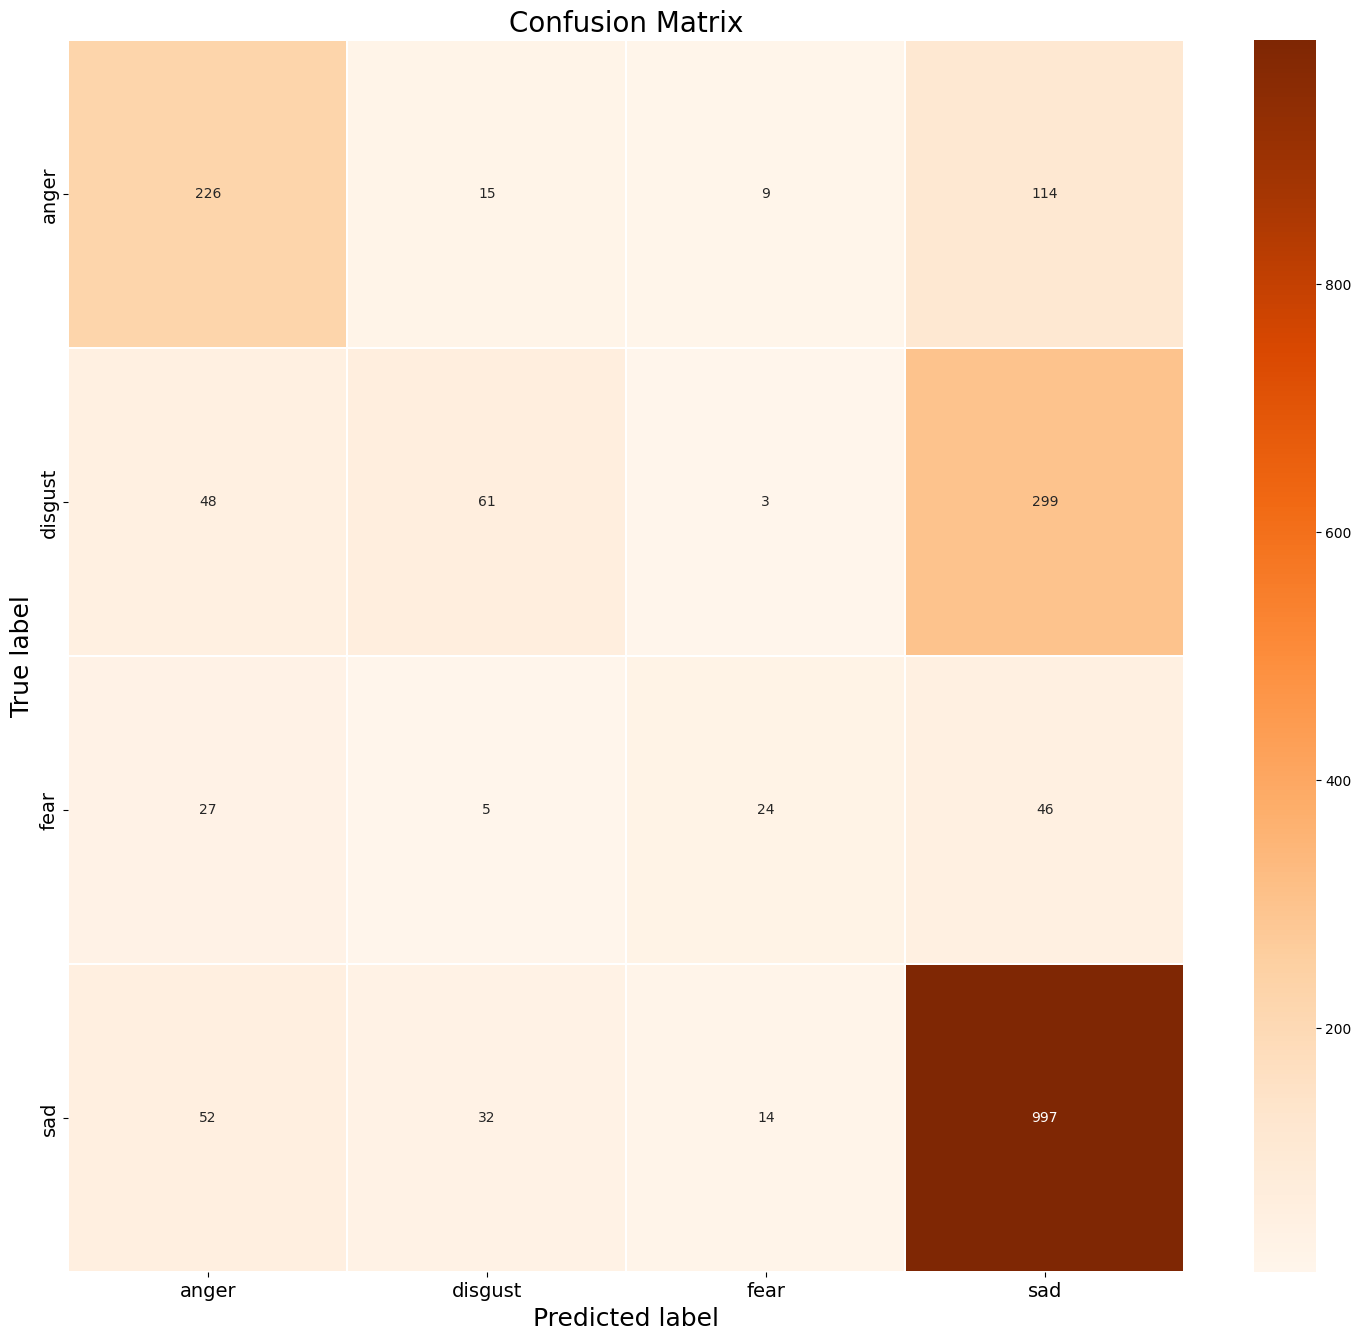

In [ ]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 定义模型
# model = ...  # 用您的PyTorch模型替换这个

def predict_classes(model, data_loader):
    all_labels = []
    all_preds = []
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)  # Move to the same device as the model
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.append(labels.cpu())  # Move back to CPU if needed for further processing
        all_preds.append(preds.cpu())  # Move back to CPU if needed for further processing
    true_labels = torch.cat(all_labels)
    predicted_labels = torch.cat(all_preds)
    return true_labels.numpy(), predicted_labels.numpy()

def create_confmat(true_labels, predicted_labels, columns, colour='Oranges', size=(20, 14)):
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm, index=[col for col in columns], columns=[col for col in columns])
    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_df, annot=True, cmap=colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize=20)
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

# 获取真实标签和预测标签
true_labels, predicted_labels = predict_classes(model, test_loader)

# 创建和显示混淆矩阵
create_confmat(true_labels, predicted_labels, ['anger', 'disgust', 'fear', 'sad'])


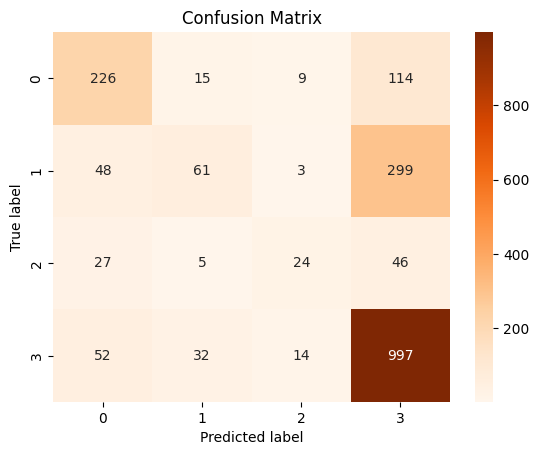

              precision    recall  f1-score      support
Anger          0.640227  0.620879  0.630404   364.000000
Disgust        0.539823  0.148418  0.232824   411.000000
Fear           0.480000  0.235294  0.315789   102.000000
Sadness        0.684753  0.910502  0.781654  1095.000000
accuracy       0.663286  0.663286  0.663286     0.663286
macro avg      0.586201  0.478774  0.490168  1972.000000
weighted avg   0.635737  0.663286  0.615254  1972.000000


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# 计算混淆矩阵
conf_mat = confusion_matrix(true_labels, predicted_labels)

# 打印分类报告
report = classification_report(true_labels, predicted_labels, target_names=['Anger', 'Disgust', 'Fear', 'Sadness'], output_dict=True)

# 将报告转换为 DataFrame
df_report = pd.DataFrame(report).transpose()

# 绘制混淆矩阵热图
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# 打印性能指标的 DataFrame
print(df_report)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6922
Precision: 0.6794
Recall: 0.5261
F1 Score: 0.5541


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.6894
Precision: 0.6807
Recall: 0.5238
F1 Score: 0.5522


### test the picture

In [ ]:
import torch
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image

In [ ]:
emotion_mapping = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "sad"
}

In [ ]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将模型移到定义的设备上
model = model.to(device)
def transform_image(image_path):
    '''
    将图像转换为模型所需的格式
    :param image_path: 图像的文件路径
    :return: 转换后的图像张量
    '''
    image = Image.open(image_path)  # 确保这里接收的是文件路径
    # 如果您要添加噪声，则取消注释下面这行
    #image = add_noise_to_image(image)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

# 确保传递给 transform_image 的是图像文件的路径
angry_dir = '/content/Expw-F/test/sad'
for image_name in os.listdir(angry_dir):
    image_path = os.path.join(angry_dir, image_name)
    if os.path.isfile(image_path):  # 确保路径指向一个文件
        test_image = transform_image(image_path)
        test_image = test_image.to(device)

        # 进行预测
        with torch.no_grad():
            outputs = model(test_image)
            _, predicted = torch.max(outputs, 1)
            print(f"Image: {image_name}, Predicted emotion: {predicted.item()}")



Image: 45035heartbroken_programmer_77.jpg, Predicted emotion: 3
Image: 17263anxious_yang_756.jpg, Predicted emotion: 2
Image: 38597crying_son_192.jpg, Predicted emotion: 1
Image: 23386fighting_black_807.jpg, Predicted emotion: 1
Image: 44491heartbroken_mother_124.jpg, Predicted emotion: 1
Image: 37355crying_manager_401.jpg, Predicted emotion: 1
Image: 34056crying_actor_105.jpg, Predicted emotion: 1
Image: 11057fighting_yang_566.jpg, Predicted emotion: 1
Image: 38180crying_president_556.jpg, Predicted emotion: 1
Image: 34592crying_asian_402.jpg, Predicted emotion: 1
Image: 37579crying_mother_40.jpg, Predicted emotion: 1
Image: 34518crying_asian_16.jpg, Predicted emotion: 3
Image: 39575crying_yang_230.jpg, Predicted emotion: 1
Image: 35632crying_european_89.jpg, Predicted emotion: 1
Image: 4512annoyed_girl_346.jpg, Predicted emotion: 1
Image: 37129crying_lady_375.jpg, Predicted emotion: 1
Image: 74940amazed_grandmother_139.jpg, Predicted emotion: 1
Image: 34482crying_american_646.jpg, Pr

In [ ]:
import os
for image_name in os.listdir(angry_dir):
    image_path = os.path.join(angry_dir, image_name)
    if os.path.isfile(image_path):
        test_image = transform_image(image_path)
        test_image = test_image.to(device)

        with torch.no_grad():
            outputs = model(test_image)
            _, predicted_idx = torch.max(outputs, 1)
            predicted_emotion = emotion_mapping[predicted_idx.item()]
            print(f"Image: {image_name}, Predicted emotion: {predicted_emotion}")

Image: 45035heartbroken_programmer_77.jpg, Predicted emotion: sad
Image: 17263anxious_yang_756.jpg, Predicted emotion: fear
Image: 38597crying_son_192.jpg, Predicted emotion: disgust
Image: 23386fighting_black_807.jpg, Predicted emotion: disgust
Image: 44491heartbroken_mother_124.jpg, Predicted emotion: disgust
Image: 37355crying_manager_401.jpg, Predicted emotion: disgust
Image: 34056crying_actor_105.jpg, Predicted emotion: disgust
Image: 11057fighting_yang_566.jpg, Predicted emotion: disgust
Image: 38180crying_president_556.jpg, Predicted emotion: disgust
Image: 34592crying_asian_402.jpg, Predicted emotion: disgust
Image: 37579crying_mother_40.jpg, Predicted emotion: disgust
Image: 34518crying_asian_16.jpg, Predicted emotion: sad
Image: 39575crying_yang_230.jpg, Predicted emotion: disgust
Image: 35632crying_european_89.jpg, Predicted emotion: disgust
Image: 4512annoyed_girl_346.jpg, Predicted emotion: disgust
Image: 37129crying_lady_375.jpg, Predicted emotion: disgust
Image: 74940ama

# test3

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# 图片预处理函数
def preprocess_image(image_path, output_size):
    # 定义图像转换操作
    transform = transforms.Compose([
        transforms.Resize(output_size),  # 缩放图像
        transforms.CenterCrop(output_size),  # 中心裁剪
        transforms.ToTensor(),  # 转换为张量
    ])
    image = Image.open(image_path).convert('RGB')  # 读取图像并转换为RGB
    image = transform(image)  # 应用图像转换
    return image

# 添加噪音的函数
'''
def add_noise(image, noise_level=0.05):
    noise = torch.randn(image.size()) * noise_level
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1)  # 确保像素值在0到1之间
'''
# 示例：预处理图像并添加噪音
#image_path = '/content/Expw-F/test/angry/1020angry_expression_174.jpg'
image_path = '/content/Expw-F/test/disgust/31895disgust_African_243.jpg' # 替换为您的图像路径
output_size = (224, 224)  # 假设模型需要的输入尺寸为224x224

processed_image = preprocess_image(image_path, output_size)
#noisy_image = add_noise(processed_image)

# 以下是使用模型进行预测的代码（根据您的具体模型进行调整）
model_resnet = models.resnet18(pretrained=True)
model = CombinedModel(num_classes=4)  # 假设有5个情绪类别
#model.load_state_dict(torch.load('path_to_your_model_weights.pth'))  # 替换为模型权重文件的路径
model.eval()  # 将模型设置为评估模式

# 情绪映射字典
emotion_mapping = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "sad"
}


# 使用模型进行预测
# 注意：noisy_image 是上述代码中添加噪音后的图像张量
processed_image = processed_image.unsqueeze(0)  # 添加批次维度
with torch.no_grad():  # 禁用梯度计算
    prediction = model(processed_image)
    print('prediction: ', prediction)
    predicted_class = torch.argmax(prediction, dim=1)
    print('predicted_class: ', predicted_class)

print(f'Predicted class: {predicted_class.item()}')
predicted_emotion = emotion_mapping[predicted_class.item()]

print(f'Predicted class: {predicted_emotion}')

prediction:  tensor([[-0.1961,  0.8316, -0.5942, -0.5582]])
predicted_class:  tensor([1])
Predicted class: 1
Predicted class: disgust
